There are already a bunch of awesome Scripts, but I wanted to step back and work with some more rudimentary models to make sure I was doing the right data preparation.

Let's start by loading our packages and data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import skew, boxcox
import statsmodels.formula.api as smf

# Load Training Data
train = pd.read_csv('../input/train.csv', dtype={'id': np.int32})

# Load Test Data
test = pd.read_csv('../input/test.csv', dtype={'id': np.int32})

Nomenclature note: The outcome variable for this competition is 'loss'. (If you read much machine learning literature, you've probably heard the term loss as in '[loss function](https://en.wikipedia.org/wiki/Loss_function)'.) That isn't exactly what we mean in this context. The 'loss' variable in this case literally refers to the amount AllState lost on the settlement. Wherever you see 'loss' in this document, assume I'm talking about the amount AllState lost, and not the output of a loss function.

Now, prediction is easier on an outcome that's normally distributed. Let's check to see if this data is:

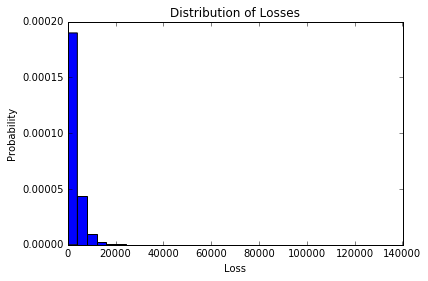

In [2]:
plt.hist(train['loss'], 30, normed=1)
plt.xlabel('Loss')
plt.ylabel('Probability')
plt.title('Distribution of Losses')
plt.show()

Wow. That isn't normally distributed at all: it's super *[skewed](https://en.wikipedia.org/wiki/Skewness)*.

In [3]:
skew(train['loss'])

3.7949281496777445

Any skew greater than one should probably catch your attention. Luckily, we have a simple counterspell! Let's *log-transform* the 'loss' variable.

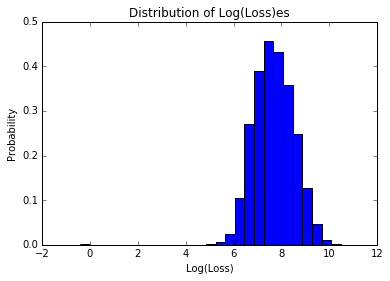

In [4]:
train['log_loss'] = np.log(train['loss'])

plt.hist(train['log_loss'], 30, normed=1)
plt.xlabel('Log(Loss)')
plt.ylabel('Probability')
plt.title('Distribution of Log(Loss)es')
plt.show()

Much Better. Now, what about our input variables? Are they similarly skewed?

In [5]:
features_numeric = test.dtypes[test.dtypes != "object"].index
features_skewed = train[features_numeric].apply(lambda x: skew(x.dropna()))
features_skewed

id       -0.002155
cont1     0.516420
cont2    -0.310939
cont3    -0.010002
cont4     0.416093
cont5     0.681617
cont6     0.461211
cont7     0.826046
cont8     0.676629
cont9     1.072420
cont10    0.354998
cont11    0.280819
cont12    0.291990
cont13    0.380739
cont14    0.248672
dtype: float64

Some of them, yeah. We can fix that by taking their log-transforms as well, but log is sort of a blunt instrument. It's easily reversible, which makes it good for the outcome. But the Box-Cox transform is a better tool for modifying our inputs. Let's apply it to any features with a skew greater than, say, .2

In [6]:
features_skewed = features_skewed[features_skewed > 0.2]
for feat in features_skewed.index:
    train[feat], lam = boxcox(train[feat] + 1)
    test[feat] = boxcox(test[feat] + 1, lam)

features_skewed = train[features_numeric].apply(lambda x: skew(x.dropna()))
features_skewed

id       -0.002155
cont1     0.003913
cont2    -0.310939
cont3    -0.010002
cont4     0.051768
cont5     0.205930
cont6     0.038875
cont7     0.054278
cont8     0.124674
cont9    -0.012653
cont10    0.020272
cont11    0.023379
cont12    0.024830
cont13    0.093885
cont14    0.067617
dtype: float64

That eliminated much of the skewness. Before we move on, however, I'd like to call attention to the way we handle `lam` in the above block. We let `boxcox` figure out the optimal `lam` using our training data, and then force it to use that same `lam` on the test data, even if it isn't necessarily optimal for the test data. The alternative approach is to bind `train` and `test` together, perform these transformations on the entire set, and then split them back apart when it comes time to build models. I've opted not to for the benefit of clarity, but possibly at the cost of some small modeling advantage.

Now, we have some categorical features we need to handle. The textbook approach to Linear Regression says you can leave categorical variables in, provided you do something like *[one-hot encode](https://en.wikipedia.org/wiki/One-hot)* them and leave out the smallest category. Personally, I prefer to replace the category with the arithmetic mean of its corresponding subset of outcomes.

In [7]:
features_categorical = [feat for feat in test.columns if 'cat' in feat]

for feat in features_categorical:
    a = pd.DataFrame(train['log_loss'].groupby([train[feat]]).mean())
    a[feat] = a.index
    train[feat] = pd.merge(left=train, right=a, how='left', on=feat)['log_loss_y']
    test[feat] = pd.merge(left=test, right=a, how='left', on=feat)['log_loss']

features_categorical = test.dtypes[test.dtypes == "object"].index

There's just one more thing to check on. Linear Regression generally doesn't handle missing values very well. Let's see if we have any:

In [8]:
counts = train.count()
len(counts[counts < train.shape[0]])

0

Not in the training dataset. Let's check `test` now:

In [9]:
counts = test.count()
len(counts[counts < test.shape[0]])

11

Rats. OK, Rather than design a elaborate solution, I'm just going to drop any columns with missing values.

In [10]:
temp = test.dropna(1)
counts = temp.count()
len(counts[counts < temp.shape[0]])

0

Cool. Now, we're ready to make a model. 

In [11]:
model = smf.ols('log_loss ~ ' + ' + '.join(temp.columns), data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_loss   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     1606.
Date:                Tue, 18 Oct 2016   Prob (F-statistic):               0.00
Time:                        20:45:49   Log-Likelihood:            -1.6157e+05
No. Observations:              188318   AIC:                         3.234e+05
Df Residuals:                  188197   BIC:                         3.246e+05
Df Model:                         120                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -129.6974     22.701     -5.713      0.000      -174.191   -85.203
id          3.358e-09   7.77e-09      0.432      0.666     -1.19e-08  1.86e-08
cat1           0.2117      0.007     30.067      0.000         0.198     0.225
cat2           0.8843      0.030     29.222      0.000         0.825     0.944
cat3          -0.8232      0.454     -1.813      0.070        -1.713     0.067
cat4           0.0221      0.027      0.830      0.407        -0.030     0.074
cat5           0.1907      0.025      7.706      0.000         0.142     0.239
cat6          -0.3005      0.293     -1.026      0.305        -0.875     0.274
cat7           0.1068      0.032      3.337      0.001         0.044     0.169
cat8           0.1646      0.103      1.592      0.111        -0.038     0.367
cat9          -1.0021      0.048    -21.089      0.000        -1.095    -0.909
cat10         -0.4859      0.028    -17.423      0.000        -0.541    -0.431
cat11         -0.5264      0.028    -18.474      0.000        -0.582    -0.471
cat12         -0.2022      0.025     -7.967      0.000        -0.252    -0.152
cat13         -0.5359      0.029    -18.568      0.000        -0.592    -0.479
cat14         -0.5296      0.047    -11.203      0.000        -0.622    -0.437
cat15         -2.4210      0.470     -5.156      0.000        -3.341    -1.501
cat16         -0.2379      0.074     -3.201      0.001        -0.384    -0.092
cat17         -0.2920      0.094     -3.103      0.002        -0.476    -0.108
cat18         -0.4254      0.135     -3.159      0.002        -0.689    -0.161
cat19         -0.2509      0.202     -1.242      0.214        -0.647     0.145
cat20         -0.2420      0.095     -2.548      0.011        -0.428    -0.056
cat21         -2.3928      0.544     -4.398      0.000        -3.459    -1.326
cat22         -1.3080      0.334     -3.914      0.000        -1.963    -0.653
cat23          0.2610      0.015     17.785      0.000         0.232     0.290
cat24          0.0569      0.020      2.910      0.004         0.019     0.095
cat25          0.5953      0.019     31.774      0.000         0.559     0.632
cat26          1.0373      0.027     38.356      0.000         0.984     1.090
cat27          4.5747      0.159     28.820      0.000         4.264     4.886
cat28          0.0926      0.016      5.971      0.000         0.062     0.123
cat29          0.2311      0.023      9.900      0.000         0.185     0.277
cat30          0.1322      0.037      3.606      0.000         0.060     0.204
cat31         -0.4536      0.151     -3.008      0.003        -0.749    -0.158
cat32          0.6868      0.058     11.933      0.000         0.574     0.800
cat33          0.1161      0.063      1.847      0.065        -0.007     0.239
cat34          0.3307      0.067      4.972      0.000         0.200     0.461
ca

There's a lot of useful information here. However, since this is a prediction challenge, I'm not interested in most of it. Instead, I'm interested in how well it can predict new values. To do that...

In [12]:
yhat = np.exp(model.predict(test))

Note that we call `np.exp` on our model predictions. Remember how we log-transformed 'loss' up at the beginning of this script? Exponentiating the outcome sort of undoes that, so our predictions will be on the same scale as 'loss' instead of 'log_loss'. Forgetting this step is a really good way to get a terrible score.

Now that we have some predictions, let's write them out and score them!

In [13]:
result = pd.DataFrame({'id': test['id'].values, 'loss': yhat})
result = result.set_index('id')
result.to_csv('simplelmprediction.csv', index=True, index_label='id')

If you submit that, it should give you a score something like 1245.99. That's a bit worse than the Random Forest Benchmark (which isn't surprising). Onward to greater refinements!

Good luck!